# Exploration des libellés d'activité

On dispose d'une base de libellés annotés de taille conséquente, et on veut avoir une idée de ce à quoi ressemblent les libellés, ce qui est nécessaire dès lors qu'on souhaite pouvoir les utiliser pour prédire le code d'activité des établissements.

Plusieurs points sont à explorer :
- Quelle est la distribution de la longueur des libellés (nombre de mots) ?
- Quelle est la distribution du nombre de phrases dans les libellés ?
- Quels sont les mots les plus fréquents dans les libellés bruts ? 
- Quels sont les mots les plus fréquents dans les libellés purgés d'une liste standard de stopwords ? Doit-on rajouter d'autres stopwords à la main ?
- Effet de la lemmatisation et racinisation ? 
- Valeurs manquantes : observations récentes ?

- Lorsque le numéro de liasse commence par "J" : liasse issue du guichet unique. Combien d'observations ? En particulier combien d'observations sans valeurs manquantes ? Distribution de la longueur des libellés ? A priori les libellés devraient être particulièrement longs et verbeux.

- Preprocessing :
    - Opérations à faire ? Standard :
        - On retire les accents
        - On retire la ponctuation
        - On réduit la casse afin que les mots avec majuscule ne se distinguent pas de leurs homologues sans majuscule
        - On retire les espaces en trop
        - On retire certaines expressions vides de sens (utilisation de regex)
        - Corrections orthographiques (pyenchant)
        - Lemmatisation et racinisation
    - Utilisation de spacy ? 
    - Utilisation de ntlk ? 

- Mots discriminants : par catégorie de la nomenclature APE, distribution des mots ? Est-ce qu'on retrouve des mots fréquemment dans toutes les catégories ? Si oui, peut-être utile de les retirer car ils ne portent pas d'information pour la tâche de classification qui nous intéresse.
- Par catégorie de la nomenclature APE, est-ce qu'il y a une différence sur la distribution de la longueur des libellés ? Possible que la longueur des libellés soit prédictive...

Idées préalables :
- Possible qu'un certain type de modèle fonctionne bien pour des libellés courts mais mal pour des libellés longs (de plusieurs phrases).



### 1) Distribution de la longueur des libellés

In [1]:
import pandas as pd

df = pd.read_parquet("../data/extraction_sirene_20220510.parquet", engine="pyarrow")

In [2]:
df.shape

(11678980, 20)

11.7M d'observations dans le jeu de données complet. On commence par retirer les données qui n'ont pas de description d'activité ou qui n'ont pas de code APE.

In [10]:
df = df.dropna(subset=["APE_SICORE", "LIB_SICORE"])

In [11]:
df.shape

(10887707, 20)

On est passé à 10.9M d'observations. Regardons la distribution du nombre de mots pour ces observations.

In [12]:
lengths = [len(x.split()) for x in df["LIB_SICORE"].tolist()]

<AxesSubplot:ylabel='Probability'>

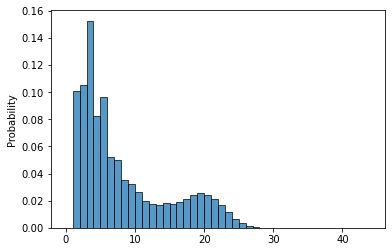

In [13]:
import seaborn as sns

sns.histplot(lengths, binwidth=1, stat="probability")

### 2) Nombre de phrases

On veut compter le nombre de phrases. Quelle est la meilleure manière de faire ? Sûrement de compter le nombre de points sauf si on a affaire à un point en fin de phrase. Le nombre de phrases serait égal au nombre de points +1. 

On regarder quelques exemples de libellés.

In [14]:
df["LIB_SICORE"].head(20)

LIA_NUM
C00903254625    VENTE A DOMICILE ET/OU SUR MARCHES DE LINGERIE...
U33071247848                             CONSULTANT EN INNOVATION
C00903254427    ACHAT ET VENTE DE TEXTILES, ACCESSOIRES ET DE ...
C74019662643    LA CERTIFICATION DE BATIMENT GARANTISSANT LA P...
C91014088499    INTERMEDIAIRE DE COMMERCE MISE EN RELATION PRO...
G34544047041    CREATION ET EXPLOITATION D'UN FONDS DE COMMERC...
C00903254666                 VENTE DE LOTS DIVERS SUR LES MARCHES
C91014088804                                    VENDRE DES MOULES
U86070530592        MISE EN RELATION D ANIMAUX AVEC L'ETRE HUMAIN
C91014088960    BIJOUX SAC ECHARPE FOULARD PORTE-MONNAIE ACCES...
C00903254237                       VENTE EN LIGNE D'OBJETS DIVERS
C00903254039    VENTE AMBULANTE DE VETEMENTS, BAZAR, LOTS EN T...
U33071249612                                           BIOENERGIE
G69514369286    CONSEILS, AUDIT ET FORMATIONS APPORTEES AUX EN...
C64024116371    MARCHAND DE BESTIAUX CHEVILLARDS EN PORCS BOUC...
U2

On retire les potentiels points à la fin des libellés après avoir remplacé les "..", "..." et "...." par "."

In [15]:
df["LIB_SICORE"] = df["LIB_SICORE"].str.replace("\\.+", ".", regex=True)
df["LIB_SICORE"] = df["LIB_SICORE"].str.rstrip(".")

In [16]:
sentence_counts = df["LIB_SICORE"].str.count("\\.") + 1

In [17]:
sentence_counts[:5]

LIA_NUM
C00903254625    2
U33071247848    1
C00903254427    1
C74019662643    2
C91014088499    1
Name: LIB_SICORE, dtype: int64

In [18]:
pd.set_option("display.max_colwidth", None)
df["LIB_SICORE"].head(5)

LIA_NUM
C00903254625      VENTE A DOMICILE ET/OU SUR MARCHES DE LINGERIE, SEXTOYS, MAROQUINERIE, CHAUSSURES, TEXTILES ET TOUS PRODUITS NON REGLEMENTES.SITE INTERNET
U33071247848                                                                                                                        CONSULTANT EN INNOVATION
C00903254427                                                         ACHAT ET VENTE DE TEXTILES, ACCESSOIRES ET DE TOUS PRODUITS NON REGLEMENTES SUR MARCHES
C74019662643    LA CERTIFICATION DE BATIMENT GARANTISSANT LA PERFORMANCE ENERGETIQUE ET/OU LA QUALITE ENVIRONNEMENTALE. TTES OPERATIONS DE FORMATION SPECIAL
C91014088499                                 INTERMEDIAIRE DE COMMERCE MISE EN RELATION PRODUCTEURS CONSOMMATEURS ORGANISATION ET DISTRIBUTION DES COMMANDES
Name: LIB_SICORE, dtype: object

In [19]:
from collections import Counter

c = Counter(sentence_counts)
print({i: round(100 * j / len(sentence_counts), 1) for i, j in c.items()})

{2: 0.8, 1: 99.1, 3: 0.1, 7: 0.0, 4: 0.0, 9: 0.0, 8: 0.0, 5: 0.0, 6: 0.0, 10: 0.0, 12: 0.0, 11: 0.0, 16: 0.0, 17: 0.0, 13: 0.0, 18: 0.0, 15: 0.0, 14: 0.0}


Quasiment tous les libellés ont 1 phrase (99.1%). On regarde certains libellés avec beaucoup de phrases soit disant ?

In [20]:
indices = sentence_counts[sentence_counts > 10].index
indices

Index(['M38028271166', 'C85014001529', 'C71044000567', 'M77027364023',
       'C01014033817', 'M02017458930', 'G69514408928', 'C69015301429',
       'M48010033713', 'M14010965729', 'M31023223415', 'M37010944152',
       'M25017164727', 'M14011007422', 'M29016000197', 'M26020500220',
       'M56012067892', 'M57021259843', 'C01016052062', 'C01016047864',
       'M38028596752', 'M56012109561', 'M14011090212', 'C21017003490',
       'M67011022290', 'C02017016841', 'M68021137979', 'M25017242994',
       'C27012019340'],
      dtype='object', name='LIA_NUM')

In [21]:
df[df.index.isin(indices)]["LIB_SICORE"]

LIA_NUM
M38028271166                                                       ETUD.ET REALIS.MOULES ET OUTIL.PREC.ETUD.TRX MEC.GLE-INJECT.MOUL.TTES MAT.ASSEM.MONT.PIEC
C85014001529            CONCEPT.REALIS.DIFFUS.COMMERC.IMP/EXP.TS OBJETS PUBLICIT.ACT.DS DOMAINE DE LA REGIE PUBLICIT.GEST.COMMERCIAL.ESPACES SUR TS SUPPORTS
C71044000567           FAB USIN. MONTAGE INST. PIECES & EQUIP. MECA. ENTRETIEN REPAMECA. ELEC. TUYAUT. CHAUFFAGE NEG. LOCA MAT IND. MANUTENTION. VOIR ANNEXE
M77027364023    INSTALL. DE SYST. HOME CINEMA AUDIOVI. DOMOTIQ. ET AUTOMATISMES INSTAL. DOMOTIQ. ET ELECTR. NEG. DE MEUBLES ET APPAR. AFFER. A L ACT. CI DES
C01014033817           PRISE DE TS INT.PARTIC.DS TTES STES AFF SS QQ FORME QCS,NOTAMM.PAR ACHAT DE DR.SOC. APP. CREATION DE STES.ASSIST.ANIM.DE CES STES.ADM
M02017458930     FAB.DE MAT.FRIGORIF.INDUST.ET CIAUX ET DE GRPES FRIGRIF.A COMPRES.REALIS.D'INST.AERAUL.OU FRIGOR.A CARACT.INDUST.MAINT.D'INST.AERAUL.FRIGOR
G69514408928    COMMERCE DETAIL. MARKETING. COMMUN

On voit qu'on a affaire à des libellés avec beaucoup d'abbréviations. Peut-être que dans ces cas là on pourrait retirer les points ? 

### 3) Mots les plus fréquents

In [48]:
import dask.bag as db

b = db.from_sequence(df["LIB_SICORE"])

wordcount = (
    b.str.replace(".", "")  # remove dots
    .str.lower()  # lower text
    .str.strip()  # remove \n and trailing spaces
    .str.split()  # split into words
    .flatten()  # chain all words lists
    .frequencies()  # compute occurences
    .topk(50, lambda x: x[1])
)  # sort and return top 10 words


wordcount.compute()  # Run all tasks and return result

[('de', 8156302),
 ('et', 4634333),
 ('la', 2152213),
 ('en', 2004337),
 ('a', 1849626),
 ('vente', 1359407),
 ('d', 1272730),
 ('ou', 1058275),
 ('tous', 1008326),
 ('l', 809399),
 ('location', 796831),
 ('conseil', 752984),
 ('gestion', 709050),
 ('non', 697299),
 ('par', 647654),
 ('des', 646364),
 ('domicile', 582594),
 ('biens', 576447),
 ('acquisition', 510259),
 ('produits', 485677),
 ('toutes', 474935),
 ('achat', 466698),
 ('le', 440941),
 ('immobiliers', 436479),
 ('dans', 400002),
 ('loueur', 396701),
 ('professionnel', 383818),
 ('aux', 372916),
 ('travaux', 372642),
 ('meuble', 368248),
 ('entreprises', 350765),
 ('commerce', 346969),
 ('pour', 340064),
 ('sur', 337818),
 ('exploitation', 333585),
 ('les', 325935),
 ('services', 325916),
 ('administration', 308978),
 ('immeubles', 299774),
 ('du', 279954),
 ('vehicules', 274594),
 ('livraison', 264465),
 ('activites', 252806),
 ('mise', 251855),
 ('commercial', 242256),
 ('vendeur', 238140),
 ('agent', 231343),
 ('fabricat

On a beaucoup de stopwords dans les 50 mots les plus fréquents, dont il va falloir se débarasser. Pour cela on utilise une liste de stopwords brute (provenant de ntlk).

In [22]:
from nltk.corpus import stopwords
import string

stopwords_ = set(stopwords.words("french") + ["a"])


def clean_lib(lib):
    # On supprime toutes les ponctuations
    lib = lib.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))
    # On supprime tous les chiffres
    lib = lib.translate(str.maketrans(string.digits, " " * len(string.digits)))

    # On supprime les stopwords et on renvoie les mots en majuscule
    return " ".join([x.lower() for x in lib.split() if x.lower() not in stopwords_])

In [23]:
from dask.dataframe import from_pandas

ddf = from_pandas(df, npartitions=30)
ddf["LIB_CLEAN"] = ddf["LIB_SICORE"].apply(
    lambda x: clean_lib(x), meta=pd.Series(dtype="str", name="LIB_CLEAN")
)
df = ddf.compute()

In [52]:
b = db.from_sequence(df["LIB_CLEAN"])

wordcount = (
    b.str.replace(".", "")  # remove dots
    .str.lower()  # lower text
    .str.strip()  # remove \n and trailing spaces
    .str.split()  # split into words
    .flatten()  # chain all words lists
    .frequencies()  # compute occurences
    .topk(50, lambda x: x[1])
)  # sort and return top 10 words


wordcount.compute()  # Run all tasks and return result

[('vente', 1410103),
 ('tous', 1008973),
 ('location', 828250),
 ('conseil', 770530),
 ('gestion', 761051),
 ('acquisition', 710521),
 ('non', 703770),
 ('domicile', 587037),
 ('biens', 583985),
 ('achat', 568459),
 ('produits', 490358),
 ('toutes', 475721),
 ('immobiliers', 461854),
 ('administration', 409413),
 ('exploitation', 405129),
 ('loueur', 396843),
 ('professionnel', 386672),
 ('travaux', 374910),
 ('meuble', 369905),
 ('entreprises', 365515),
 ('commerce', 357620),
 ('immeubles', 339764),
 ('services', 333912),
 ('propriete', 292022),
 ('construction', 279773),
 ('vehicules', 278805),
 ('livraison', 265406),
 ('activites', 259047),
 ('mise', 252682),
 ('autres', 247044),
 ('commercial', 246528),
 ('vendeur', 238224),
 ('fabrication', 237938),
 ('agent', 233888),
 ('velo', 225287),
 ('activite', 218491),
 ('prestations', 215087),
 ('restauration', 213459),
 ('repas', 212337),
 ('bail', 211293),
 ('accessoires', 209467),
 ('autrement', 208227),
 ('prise', 199882),
 ('immobili

On semble avoir bien retire les principaux mots vides de sens.

### Lemmatisation

In [47]:
sample_df = df.sample(frac=0.1)
sample_df.shape

(1088771, 21)

In [25]:
import spacy

nlp = spacy.load("fr_core_news_sm", disable=["parser", "ner"])

lemmatized_libs = []
for doc in nlp.pipe(sample_df["LIB_CLEAN"], n_process=30):
    lemmatized_libs.append(" ".join([token.lemma_ for token in doc]))

53s. pour 1% du dataset

In [26]:
len(lemmatized_libs)

108877

In [27]:
sample_df["LIB_LEMM"] = lemmatized_libs
sample_df.head()

,DATE,TROUVE_XML,TROUVE_BILAN,LIB_LIASSE_ETAB_E70,LIB_LIASSE_ETAB_E71,LIB_LIASSE_UL_U21,LIB_SICORE,EVT_LIASSE,EVT_SICORE,AUTO,...,NAT_LIASSE,NAT_SICORE,SURF,APE_BILAN,APE_SICORE,TYPE_BILAN,TYPE_SICORE,CFE,LIB_CLEAN,LIB_LEMM
LIA_NUM,,,,,,,,,,,,,,,,,,,,,
M57031683800,2021-01-19 19:34:28,True,True,TOUS TRAVAUX DE PEINTURE EN BATIMENT,TOUS TRAVAUX DE PEINTURE EN BATIMENT,TOUS TRAVAUX DE PEINTURE EN BATIMENT,TOUS TRAVAUX DE PEINTURE EN BATIMENT,01P,01P,M,...,14,14,None,4334Z,4334Z,0,2,M,tous travaux peinture batiment,tout travail peintur batiment
U34074344202,2020-02-14 10:06:32,True,True,concept artist/Illustrateur.,concept artist/Illustrateur,concept artist/Illustrateur.,CONCEPT ARTIST ILLUSTRATEUR,01P,01P,X,...,99,99,None,9003A,9003A,2,1,U,concept artist illustrateur,concept artist illustrateur
U44077935616,2021-09-22 08:57:25,True,True,VENDEUR A DOMICILE,VENDEUR A DOMICILE,VENDEUR A DOMICILE,VENDEUR A DOMICILE,01P,01P,I,...,99,99,None,4799A,4799A,0,2,U,vendeur domicile,vendeur domicil
G73811882388,2021-09-07 19:34:02,True,True,Loueur en meublé non professionnel,Loueur en meublé non professionnel,Loueur en meublé non professionnel,LOUEUR EN MEUBLE NON PROFESSIONNEL,01P,01P,I,...,99,99,None,6820A,6820A,1,1,G,loueur meuble non professionnel,loueur meuble non professionnel
M76021566880,2017-07-07 09:10:45,True,False,POSE DE PLAQUES DE PLATRE,POSE DE PLAQUES DE PLATRE,POSE DE PLAQUES DE PLATRE,POSE DE PLAQUES DE PLATRE,05P,05P,M,...,14,14,None,None,4331Z,None,2,M,pose plaques platre,pose plaque platr


On regarde le temps que ça prend en fonction du paramètre `n_process`.

In [48]:
nlp = spacy.load("fr_core_news_sm", disable=["parser", "ner"])

In [35]:
lemmatized_libs = []
for doc in nlp.pipe(sample_df["LIB_CLEAN"], n_process=-1, batch_size=1000):
    lemmatized_libs.append(" ".join([token.lemma_ for token in doc]))

Pas d'influence sur la rapidité de la lemmatisation...

In [53]:
from joblib import Parallel, delayed


def lemmatize_pipe(doc):
    return " ".join([token.lemma_ for token in doc])


def chunker(iterable, total_length, chunksize):
    return (iterable[pos : pos + chunksize] for pos in range(0, total_length, chunksize))


def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]


def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=1000):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe


def preprocess_parallel(texts, chunksize=100, n_jobs=50):
    executor = Parallel(n_jobs=n_jobs, backend="multiprocessing", prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(df), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

Tout le dataset

In [54]:
lemmatized_libs = preprocess_parallel(df["LIB_CLEAN"], chunksize=100000)
len(lemmatized_libs)

10887707

In [58]:
lemmatized_libs[:20]

['education canin',
 'amelioration vecu enfant subir intervention chirurgical',
 'marche nordique',
 'codage logiciel informatique service fonctionnement logiciel informatique',
 'force accompagnemer juridique social jeunesse',
 'sport',
 'sportif',
 'musiqu',
 'defense proprietaire peniche aupre institution preservation environnement bois boulogn',
 'commerce bien culturel',
 'developpement culturel',
 'organisation festival musiqu eco responsable',
 'production cinematographiqu audiovisuel',
 'activite organisation associatif',
 'ressourcerie',
 'aide humanitaire',
 'collect don subvention mettre place projet ecologiqu milieu scolaire',
 'street art',
 "promouvoir groupe musiqu rock'n'roll metal amateur",
 'visite accompagnement malade']

In [57]:
df["LIB_CLEAN"][:10]

LIA_NUM
A00990000014                                                                               education canine
A00990000022                                  amelioration vecu enfants subissent intervention chirurgicale
A00990000030                                                                                marche nordique
A00990000048                   codage logiciel informatique services fonctionnement logiciels informatiques
A00990000063                                                force accompagnement juridique sociale jeunesse
A00990000089                                                                                          sport
A00990000105                                                                                       sportive
A00990000113                                                                                        musique
A00990000121    defense proprietaires peniches aupres institutions preservation environnement bois boulogne
A00990000139        

Number of different words

In [60]:
import dask.bag as db

b = db.from_sequence(df["LIB_CLEAN"])

distinct_words = (
    b.str.replace(".", "")
    .str.lower()  # lower text
    .str.strip()  # remove \n and trailing spaces
    .str.split()  # split into words
    .flatten()  # chain all words lists
    .distinct()
    .count()
)


distinct_words.compute()

174513

In [62]:
b = db.from_sequence(df["LIB_CLEAN"])

sample = (
    b.str.replace(".", "")
    .str.lower()  # lower text
    .str.strip()  # remove \n and trailing spaces
    .str.split()  # split into words
    .flatten()  # chain all words lists
    .distinct()
    .random_sample(0.001)
)


sample = sample.compute()

In [63]:
sample

['programme',
 'ssoutenir',
 'econnique',
 'malices',
 'noels',
 'aubrac',
 'gasquet',
 'hainnevillais',
 'couteau',
 'polynesien',
 'intermed',
 'inves',
 'trouv',
 'oleicoles',
 'ingenerie',
 'terminaison',
 'alter',
 'aliemnation',
 'hamac',
 'trnasport',
 'gors',
 'modifiees',
 'comception',
 'plas',
 'reglementeenon',
 'vehiclee',
 'ntt',
 'relativ',
 'essaims',
 'etiquetages',
 'loptimization',
 'antiparasitaires',
 'rad',
 'dimploi',
 'vacanciers',
 'avin',
 'patrimoinial',
 'semiconducteurs',
 'vutements',
 'toners',
 'validtion',
 'renovelable',
 'articlenon',
 'goji',
 'lanques',
 'dautom',
 'fumeus',
 'heat',
 'liretie',
 'ecoursier',
 'économie',
 'precepte',
 'reulation',
 'fruist',
 'patsagistes',
 'deatils',
 'superparche',
 'srrvices',
 'associesupermarche',
 'odem',
 'gazebos',
 'tisannes',
 'cosetterie',
 'oscietes',
 'alimentairesvente',
 'resorber',
 'folio',
 'improt',
 'vpn',
 'roulantes',
 'precol',
 'généralem',
 'réception',
 'conseilconcurentiel',
 'consttruct

In [61]:
b = db.from_sequence(lemmatized_libs)

distinct_words = (
    b.str.replace(".", "")
    .str.lower()  # lower text
    .str.strip()  # remove \n and trailing spaces
    .str.split()  # split into words
    .flatten()  # chain all words lists
    .distinct()
    .count()
)


distinct_words.compute()

164760

Possible de faire de la NER peut-être pour aller plus loin dans le preprocessing ?

In [66]:
nlp = spacy.load("fr_core_news_sm", disable=["parser"])
doc = nlp("San Francisco est une ville des USA")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

San Francisco 0 13 LOC
USA 32 35 LOC


In [69]:
ent_dict = {}
for doc in nlp.pipe(sample_df["LIB_CLEAN"], n_process=30):
    for ent in doc.ents:
        ent_dict[ent] = ent.label_

In [70]:
ent_dict

{animalerie: 'LOC',
 nettoyage: 'PER',
 medecin orl: 'PER',
 conseil entreprises: 'ORG',
 boutique pret: 'PER',
 vente distance catalogue: 'PER',
 vente correspondance: 'PER',
 conseil entreprises: 'ORG',
 creperie: 'LOC',
 conseil logistique: 'ORG',
 viager gestion: 'PER',
 conseil entreprises: 'ORG',
 conseil entreprises: 'ORG',
 propriete: 'MISC',
 michel ricard: 'PER',
 coursier velo: 'PER',
 vente correspondance: 'PER',
 tapissier decorateur: 'MISC',
 medecin: 'PER',
 societe cloud: 'PER',
 montpellier gestion: 'LOC',
 aeriens: 'PER',
 vente correspondance: 'PER',
 loueur meubles: 'PER',
 conseil entreprises: 'ORG',
 vente mobilier: 'PER',
 vente correspondance: 'PER',
 vente correspondance: 'PER',
 conseil entreprises: 'ORG',
 conseil art: 'ORG',
 negoce: 'PER',
 conseil entreprises: 'ORG',
 conseil entreprises: 'ORG',
 france: 'LOC',
 loueur meubles: 'PER',
 moniteur bateau ecole: 'PER',
 dom: 'MISC',
 gestion biens immobiliers: 'MISC',
 societe objet: 'PER',
 france: 'LOC',
 ve

Pas vraiment de moyen d'utiliser ça apparemment.

### 3.5) Beaucoup de nombres ?

In [75]:
b = db.from_sequence(df["LIB_CLEAN"])

sample = (
    b.str.replace(".", "")
    .str.lower()  # lower text
    .str.strip()  # remove \n and trailing spaces
    .str.split()  # split into words
    .flatten()  # chain all words lists
    .filter(lambda x: x.isnumeric())
    .count()
)


sample = sample.compute()

In [76]:
sample

0

Pas de nombres.

### 4) Valeurs manquantes : observations récentes ? 

Quels sont les observations pour lesquelles il y a un libellé manquant ou un code APE manquant ? 

In [3]:
import pandas as pd

df = pd.read_parquet("../data/extraction_sirene_20220510.parquet", engine="pyarrow")
nan_df = df[df[["APE_SICORE", "LIB_SICORE"]].isnull().any(axis=1)]

In [5]:
nan_df.head(30)

,DATE,TROUVE_XML,TROUVE_BILAN,LIB_LIASSE_ETAB_E70,LIB_LIASSE_ETAB_E71,LIB_LIASSE_UL_U21,LIB_SICORE,EVT_LIASSE,EVT_SICORE,AUTO,SED_LIASSE,SED_SICORE,NAT_LIASSE,NAT_SICORE,SURF,APE_BILAN,APE_SICORE,TYPE_BILAN,TYPE_SICORE,CFE
LIA_NUM,,,,,,,,,,,,,,,,,,,,
M83014424076,2014-09-22 14:39:38,False,False,None,None,None,PROTHESISTE ONGULAIRE,None,01P,None,None,None,None,12,None,None,None,None,B,M
U75070205272,2014-09-23 15:01:45,True,False,SERVICES DES COURSIERS URBAINS INDEPENDANTS,SERVICES DES COURSIERS URBAINS INDEPENDANTS,SERVICES DES COURSIERS URBAINS INDEPENDANTS,SOCIOLOGUE,01P,None,Y,None,None,99,12,None,None,None,None,B,U
U33071249729,2014-09-22 14:17:33,True,False,ARTISTE,ARTISTE,ARTISTE,ARTISTE,01P,05P,I,None,None,11,11,None,None,None,None,B,U
G61811847668,2014-09-23 08:03:05,True,False,LOUEUR EN MEUBLE NON PROFESSIONNEL,LOUEUR EN MEUBLE NON PROFESSIONNEL,LOUEUR EN MEUBLE NON PROFESSIONNEL,LOUEUR EN MEUBLE NON PROFESSIONNEL,05P,54P,I,None,None,None,None,None,None,None,None,B,G
C31014516922,2014-09-25 03:07:48,True,False,"prise de participation dans des sociétés, tout...",prise de participation dans des sociétés,"prise de participation dans des sociétés, tout...",PRISE DE PARTICIPATION DANS DES SOCIETES,01M,01M,C,None,None,12,12,None,None,None,None,B,C
M60012706532,2014-09-24 08:53:53,True,False,POSE DE PLAQUES DE PLATRE,POSE DE PLAQUES DE PLATRE,POSE DE PLAQUES DE PLATRE,POSE DE PLAQUES DE PLATRE,01P,05P,M,None,None,14,14,None,None,None,None,B,M
U75070202113,2014-09-23 04:29:35,True,False,KIOSQUE A JOURNAUX,KIOSQUE A JOURNAUX,None,ACHAT REVENTE DE CARTES POSTALES ARTISANALES S...,11P,01P,L,None,None,None,10,None,None,None,None,B,U
U13071060633,2014-09-24 09:07:30,True,False,Vendeur a domicile,Vendeur a domicile,Vendeur a domicile,VENDEUR A DOMICILE,01P,01P,I,None,None,None,None,None,None,None,None,B,U
M13010436038,2014-09-22 15:00:52,True,False,PROTHESISTE ONGULAIRE,PROTHESISTE ONGULAIRE,None,PROTHESISTE ONGULAIRE,11P,11P,Z,None,None,12,12,None,None,None,None,B,M


### 5) Liasses du guichet unique

In [6]:
import pandas as pd

df = pd.read_parquet("../data/extraction_sirene_20220510.parquet", engine="pyarrow")

In [ ]:
df_gu = df[df["LIA_NUM"].str[:1] == "J"]
df_gu.shape

: 